In [1]:
!pip install gpflow
!pip install utils
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip install eofs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 43.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.9 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102749 sha256=8e563b38520658d8033f1d81ba8f2bdb24e22a834ddeaeb1be062cf20dc67cde
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from glob import glob

import tensorflow as tf
import gpflow
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [3]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Utilis


In [4]:
import numpy as np
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
# data_path = './data/train_val/'
data_path = "/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/"

min_co2 = 0.
max_co2 = 9500
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.8
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4


def create_predictor_data(data_sets, n_eofs=5):
    """
    Args:
        data_sets list(str): names of datasets
        n_eofs (int): number of eofs to create for aerosol variables
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs, (so2_solver, bc_solver)


def get_test_data(file, eof_solvers, n_eofs=5):
    """
    Args:
        file str: name of datasets
        n_eofs (int): number of eofs to create for aerosol variables
        eof_solvers (Eof_so2, Eof_bc): Fitted Eof objects to use for projection
    """

    # Create training and testing arrays
    X = xr.open_dataset(data_path + f"inputs_{file}.nc")

    so2_pcs = eof_solvers[0].projectField(X["SO2"], neofs=5, eofscaling=1)
    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    bc_pcs = eof_solvers[1].projectField(X["BC"], neofs=5, eofscaling=1)
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs


def create_predictdand_data(data_sets):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
    return Y


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from eofs.xarray import Eof


def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """
    n_eofs=5
    min_co2 = 0.
    max_co2 = 9500
    def normalize_co2(data):
       return data / max_co2

    def un_normalize_co2(data):
        return data * max_co2

    min_ch4 = 0.
    max_ch4 = 0.8
    def normalize_ch4(data):
       return data / max_ch4

    def un_normalize_ch4(data):
        return data * max_ch4
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)

    return X, length_all,(so2_solver, bc_solver),inputs


def prepare_predictand(data_sets,data_path,time_reindex=True):

    if isinstance(data_sets, str):
        data_sets = [data_sets]
    Y_all = []
    length_all = []

    for file in data_sets:

        data = xr.open_dataset(data_path + f"/outputs_{file}.nc")
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    inp = xr.concat([xr.open_dataset(data_path + f"/outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    # Convert the precip values to mm/day
    inp["pr"] *= 86400
    inp["pr90"] *= 86400


    return Y, length_all,inp


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [6]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [7]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr,X_length,solver,X_inputs = prepare_predictor(train_files,train_path)
y_train_xr,y_train_length,y_train_inputs  = prepare_predictand(train_files,train_path)

#Testing set
X_test_xr, _ , solver, X_test_inputs = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ , y_test_inputs = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [ ]:
y_train_length

array([165,  86,  86,  86, 165, 165])

In [8]:



y_train_df = y_train_xr["diurnal_temperature_range"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

In [ ]:
X_test_inputs

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4
2015,0.161692,0.467171,-1.848120,-2.997157,-1.370376,0.819766,4.357775,-1.810749,-3.237989,-2.440683,1.265845,4.054046
2016,0.165480,0.467151,-1.770935,-2.737577,-1.240559,0.522505,3.037672,-1.691530,-2.936678,-1.919931,0.909636,2.709123
2017,0.169305,0.467130,-1.693749,-2.477998,-1.110743,0.225244,1.717568,-1.572311,-2.635367,-1.399180,0.553427,1.364200
2018,0.173166,0.467110,-1.616564,-2.218418,-0.980926,-0.072018,0.397465,-1.453091,-2.334057,-0.878428,0.197218,0.019278
2019,0.177064,0.467090,-1.539379,-1.958839,-0.851110,-0.369279,-0.922639,-1.333872,-2.032746,-0.357676,-0.158991,-1.325645
...,...,...,...,...,...,...,...,...,...,...,...,...
2096,0.469755,0.352172,1.435515,-0.896998,0.488574,-1.507813,-0.363902,1.296894,-0.984599,0.962083,-1.545024,0.549357
2097,0.471474,0.351729,1.454090,-0.900787,0.404335,-1.639047,-0.594456,1.311303,-1.044758,0.990998,-1.733059,0.606642
2098,0.473128,0.351287,1.472666,-0.904576,0.320097,-1.770280,-0.825010,1.325713,-1.104916,1.019913,-1.921094,0.663928
2099,0.474718,0.350845,1.491241,-0.908365,0.235858,-1.901514,-1.055564,1.340122,-1.165075,1.048827,-2.109129,0.721214


In [9]:
# Standardize the predictors
mean, std = X_inputs.mean(), X_inputs.std()

X_train_df   = (X_inputs - mean)/std
X_test_df    = (X_test_inputs - mean)/std

X_train = X_train_df.to_numpy()
X_test  = X_test_df.to_numpy()

In [10]:
# Standardize the predictand
y_train    = y_train_df.to_numpy().astype(np.float64)
train_dir_mean, train_dir_std = y_train.mean(), y_train.std()
y_train    = (y_train - train_dir_mean) / train_dir_std


print(X_train.shape,y_train.shape,X_test.shape)

(753, 12) (753, 13824) (86, 12)


In [13]:
X_inputs

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4
0,0.000020,0.039132,-0.692262,-0.130168,-0.232393,-1.030091,-0.124014,-0.684515,-0.666947,-0.537510,-0.028525,-0.113818
1,0.000040,0.039677,-0.692450,-0.126097,-0.237947,-1.002077,-0.110012,-0.687033,-0.663856,-0.545009,-0.005502,-0.125350
2,0.000060,0.040222,-0.693939,-0.145096,-0.220875,-1.001310,-0.110182,-0.683973,-0.664691,-0.542393,-0.004230,-0.127326
3,0.000082,0.040767,-0.695386,-0.164126,-0.203961,-0.999653,-0.110238,-0.681914,-0.665113,-0.541201,-0.003263,-0.128716
4,0.000107,0.041312,-0.702971,-0.281864,-0.087136,-1.120270,-0.172785,-0.655500,-0.682270,-0.499379,-0.101005,-0.084503
...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.000000,0.000000,1.644716,-0.493645,-1.528110,-0.037400,-0.880122,0.390156,2.024466,-2.256224,-1.164653,1.216913
749,0.000000,0.000000,1.725448,-0.477916,-1.591776,-0.165963,-1.011641,0.383776,2.110970,-2.351688,-1.119783,1.259567
750,0.000000,0.000000,1.757629,-0.437390,-1.574078,-0.259145,-1.005115,0.330982,2.127178,-2.241587,-1.170689,1.267201
751,0.000000,0.000000,1.813566,-0.434678,-1.608055,-0.366531,-1.067975,0.279028,2.121803,-2.249532,-1.236042,1.451814


In [11]:
# Define the kernels Matern32, full list here https://gpflow.github.io/GPflow/develop/api/gpflow/kernels/index.html
#gpflow.kernels.Matern32
#class gpflow.kernels.Matern32(variance=1.0, lengthscales=1.0, **kwargs)[source]
#Bases: IsotropicStationary
#The Matern 3/2 kernel. Functions drawn from a GP with this kernel are once differentiable. The kernel equation is
#k(r) = σ² (1 + √3r) exp{-√3 r}

#kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
#kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

# The Exponential kernel. It is equivalent to a Matern12 kernel with doubled lengthscales
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])
kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

# Define the model
np.random.seed(5)
mean  = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train, y_train),
                          kernel=kernel,
                          mean_function=mean)

# Define optimizer
opt = gpflow.optimizers.Scipy()

In [12]:
# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 10345799.031704595
        x: [ 5.217e+00  2.445e+00 ... -9.513e-01 -2.109e-01]
      nit: 543
      jac: [ 4.984e+00  3.396e-01 ...  5.883e+01 -3.029e+01]
     nfev: 637
     njev: 637
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

In [13]:
y_pred = model.predict_y(X_test)

In [ ]:
train_dir_std


latitude  longitude
-90.0     0.0          0.116346
          2.5          0.116345
          5.0          0.116340
          7.5          0.116342
          10.0         0.116343
                         ...   
 90.0     347.5        0.341174
          350.0        0.341317
          352.5        0.341506
          355.0        0.341745
          357.5        0.342040
Length: 13824, dtype: float32

In [14]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test)
posterior_mean   = standard_posterior_mean * train_dir_std + train_dir_mean
posterior_std    = np.sqrt(standard_posterior_var) * train_dir_std

In [15]:
y_test_pre_mean = np.reshape(posterior_mean,[posterior_mean.shape[0], 96, 144])
y_test_pre_std  = np.reshape(posterior_std,[posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values,
                                 'latitude': X_test_xr.latitude.values,
                                 'longitude': X_test_xr.longitude.values},
                             data_vars=dict(diurnal_temperature_range_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean),
                                            diurnal_temperature_range_std=(['time', 'latitude', 'longitude'], y_test_pre_std)))

In [ ]:
y_test_pre

<xarray.Dataset>
Dimensions:    (time: 86, latitude: 96, longitude: 144)
Coordinates:
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    tas_mean   (time, latitude, longitude) float64 1.019e-07 ... 1.46e-06
    tas_std    (time, latitude, longitude) float64 6.021e-06 ... 6.062e-06

In [16]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])
posterior_pr_data = xr.DataArray(posterior_pr, dims=y_test_xr.tas.dims, coords=y_test_xr.diurnal_temperature_range.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=y_test_xr.tas.dims, coords=y_test_xr.diurnal_temperature_range.coords)

In [17]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.diurnal_temperature_range[35], y_test_pre.diurnal_temperature_range_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.diurnal_temperature_range[85], y_test_pre.diurnal_temperature_range_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.diurnal_temperature_range[30:41], y_test_pre.diurnal_temperature_range_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.diurnal_temperature_range[75:], y_test_pre.diurnal_temperature_range_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.diurnal_temperature_range[35:], y_test_pre.diurnal_temperature_range_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.diurnal_temperature_range[-20:].mean(dim='time'), y_test_pre.diurnal_temperature_range_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 0.1369354759869784
RMSE at 2100: 0.15060000044397012
RMSE 2045-2055: 0.1393116246428445
RMSE 2090-2100: 0.1637650597382425
RMSE 2050-2100: 0.15123625801384374
RMSE average last 20y: 0.0992274931356239


In [18]:
!pip install cartopy

In [19]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
  Using cached shapely-2.0.1-cp310-cp310-linux_x86_64.whl


In [20]:
import cartopy.crs as ccrs


[Text(0.5, 1.0, 'Difference')]

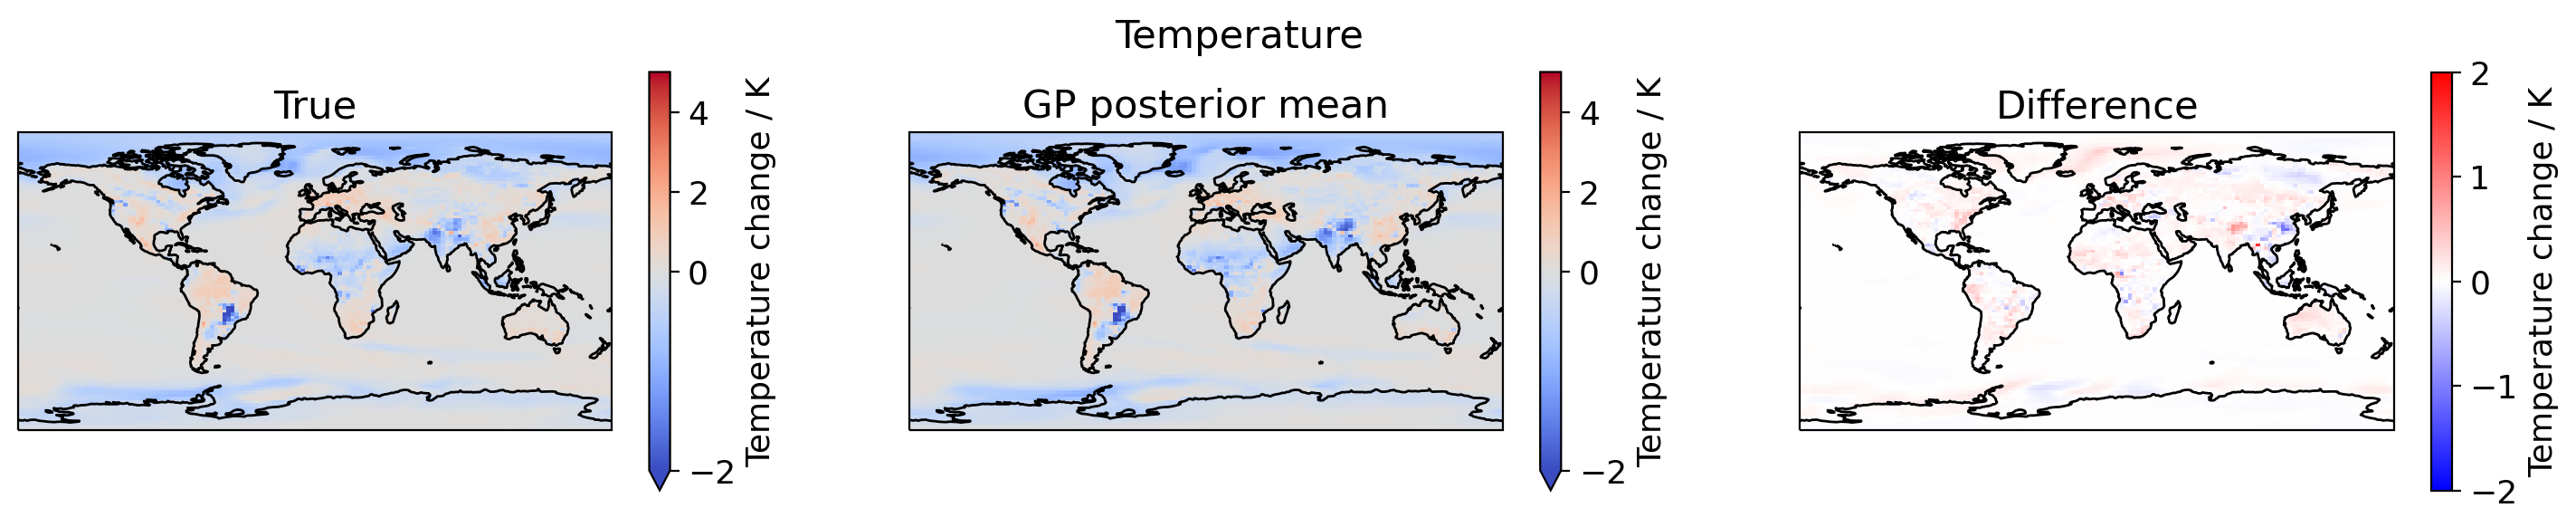

In [35]:
import cartopy.crs as ccrs
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
y_test_xr.diurnal_temperature_range.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                             cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
y_test_pre.diurnal_temperature_range_mean.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = y_test_xr.diurnal_temperature_range - y_test_pre.diurnal_temperature_range_mean
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

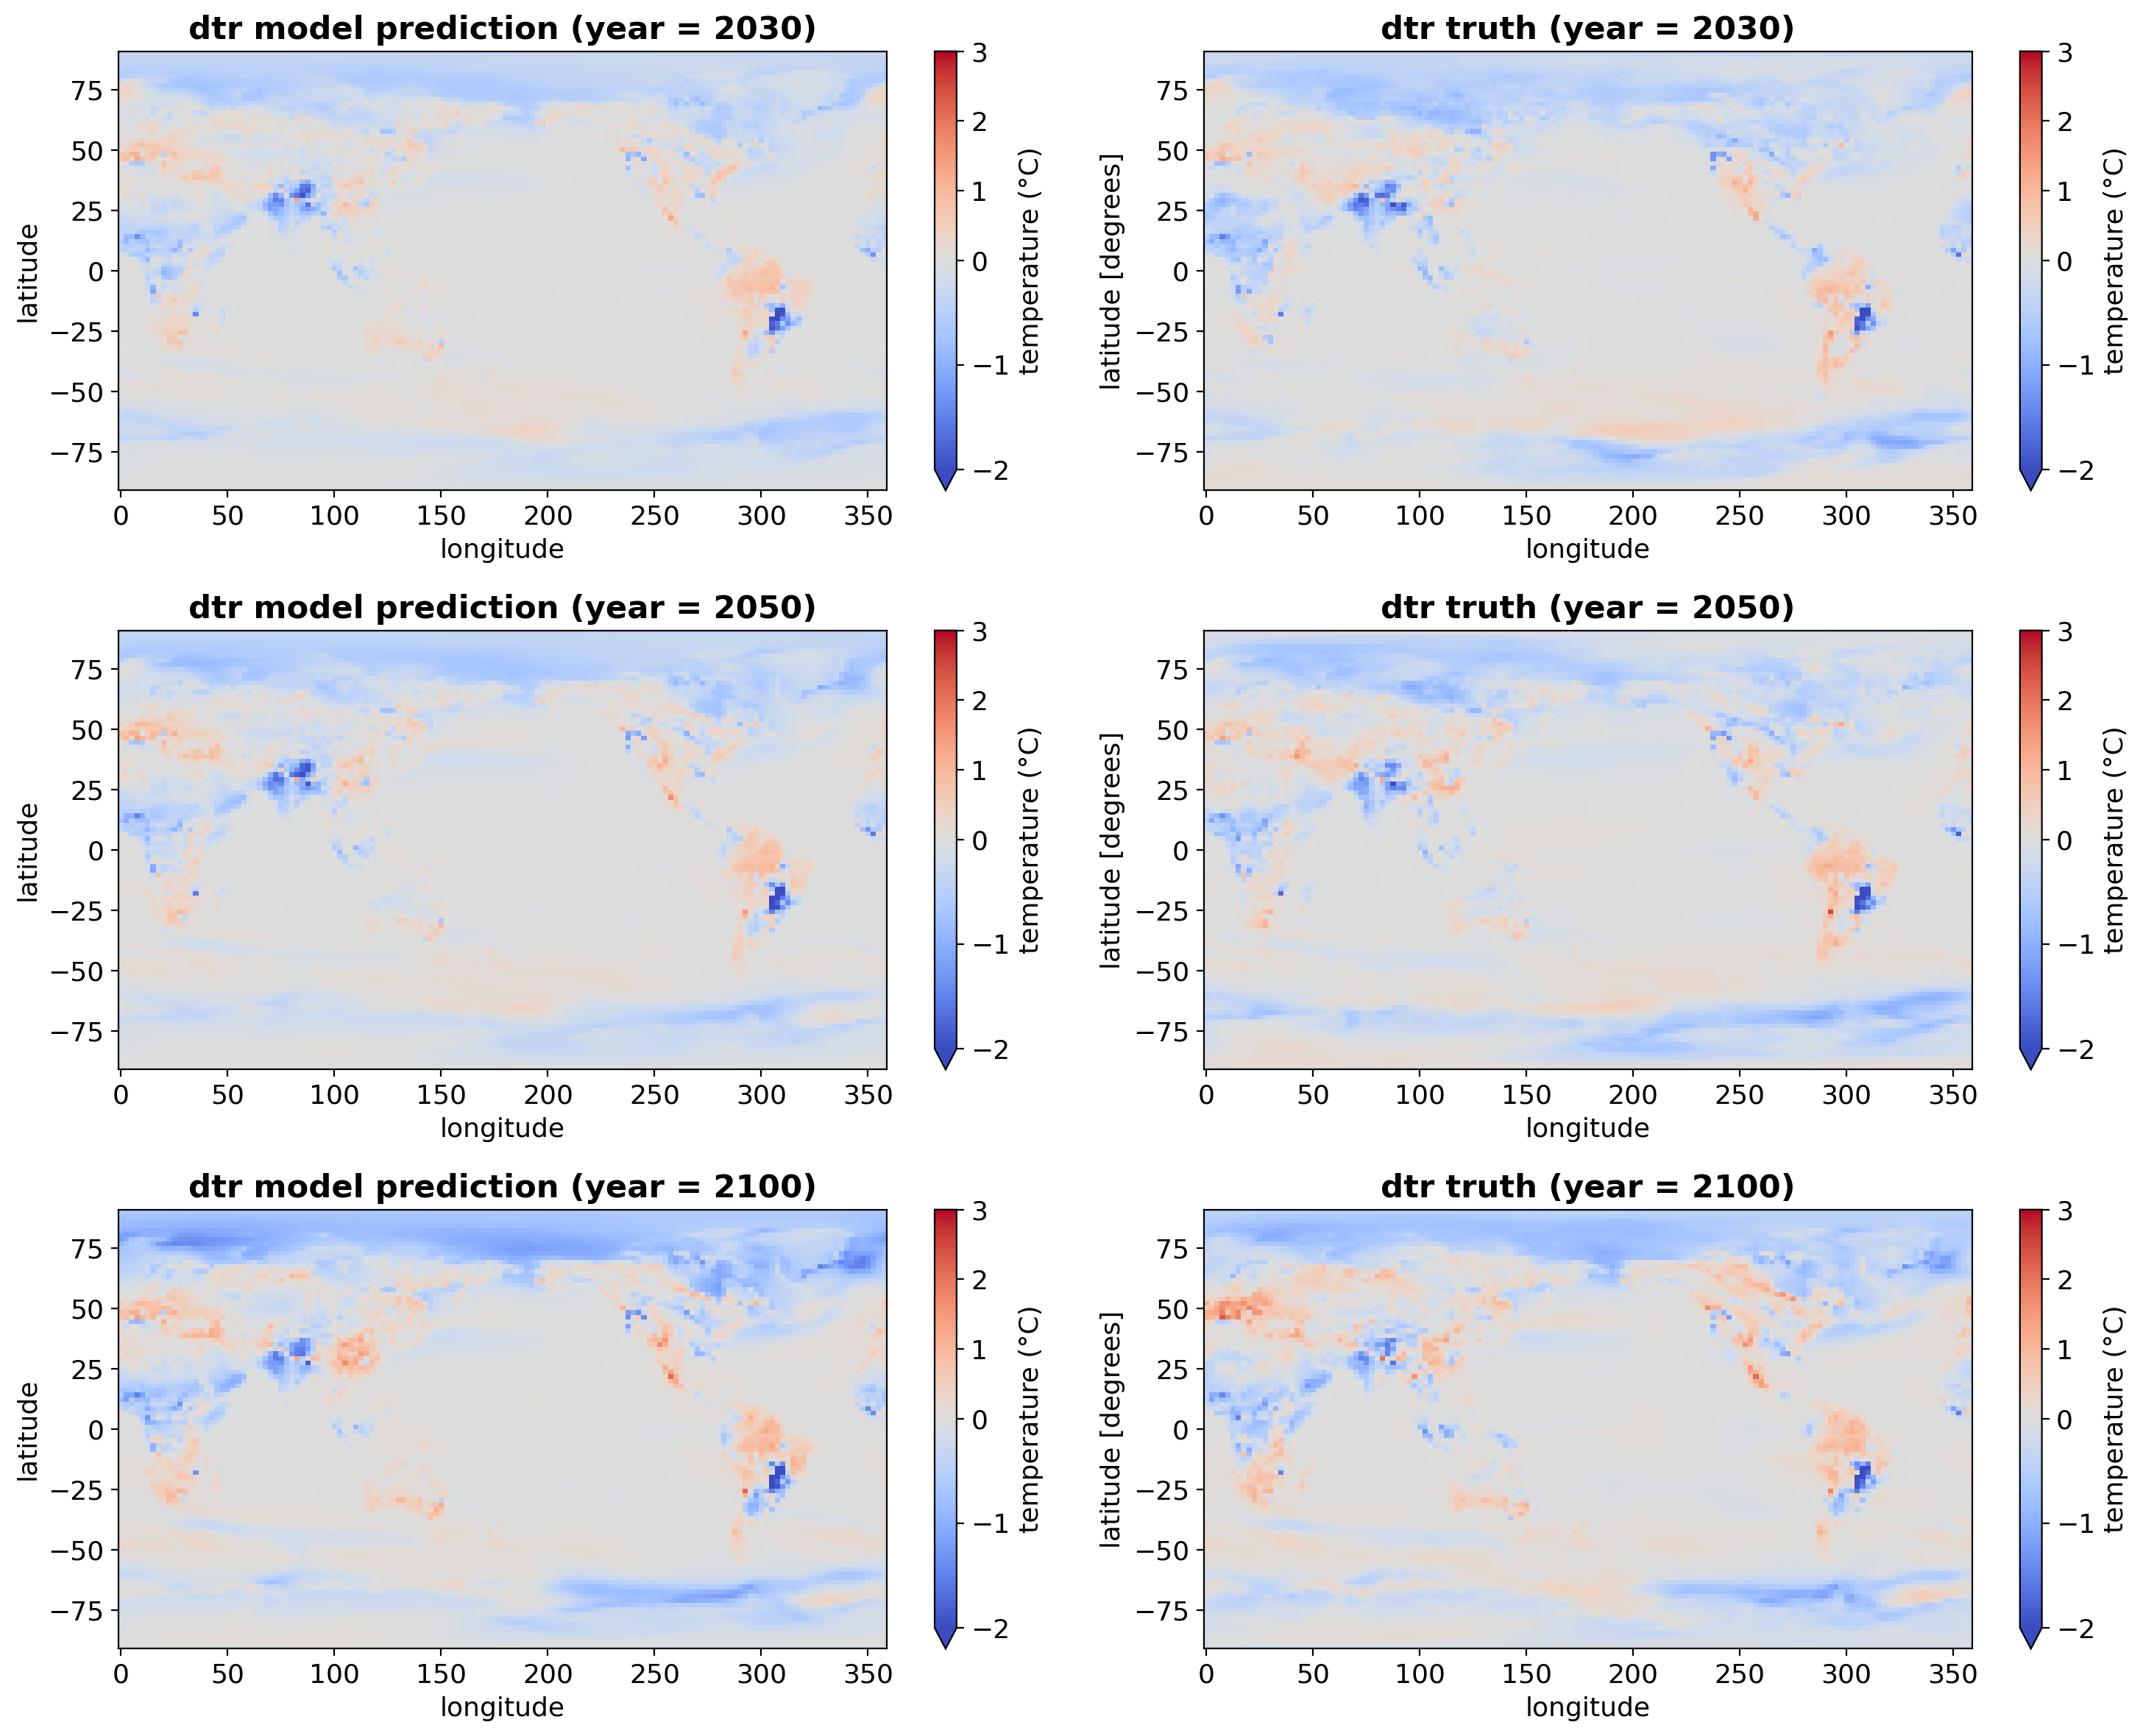

In [28]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 3
cmap = 'coolwarm'
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
divnorm2 = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=2)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

y_test_pre.diurnal_temperature_range_mean.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.diurnal_temperature_range.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.diurnal_temperature_range_mean.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.diurnal_temperature_range.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.diurnal_temperature_range_mean.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.diurnal_temperature_range.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'dtr model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'dtr truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

In [33]:
# Save predictions
posterior_pr_data.to_netcdf('/content/gdrive/MyDrive/climatebench-gp-posterior-mean-dtr-test-2019-2100.nc')
posterior_pr_std_data.to_netcdf('/content/gdrive/MyDrive/climatebench-gp-posterior-std-dtr-test-2019-2100.nc')

In [ ]:
posterior_pr_data = xr.DataArray(posterior_pr, dims=y_test_xr.tas.dims, coords=y_test_xr.diurnal_temperature_range.coords)